In [1]:
#python import statements

import numpy as np
import matplotlib.pyplot as plt
import cmath
import math
import itertools

In [2]:
#qiskit import statements

from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.quantum_info import random_statevector, Statevector
import qiskit.quantum_info as qi
from qiskit.circuit import Parameter #allows us to have parameterized gates
from qiskit.extensions import UnitaryGate

# Use Aer's qasm_simulator
simulator = AerSimulator()

In [3]:
#define the parameters that we want to work with 
#TODO: add in the definition of the second parameter
phi_1, phi_2 = Parameter('phi_1'), Parameter('phi_2')

#for now, manually setting the parameters to be floats 
#phi_1 = -1
#phi_2 = -2

In [4]:
#helper function that takes in the angle as a parameter and returns the B matrix (B^dagger * B = P)
def add_proj_gate(angle, cr):
    cr.rz(-1*angle, [0, 3])
    cr.ry(-0.5*math.pi, [0, 3])
    cr.rz(angle, [0, 3])

def add_proj_gate_conj(angle, cr):
    cr.rz(-1*angle, [0, 3])
    cr.ry(0.5*math.pi, [0, 3])
    cr.rz(angle, [0, 3])

#print(get_proj_gate(0.5*math.pi))

In [5]:
# Create the ansatz circuit
circuit = QuantumCircuit(6) #need 2N qubits in order to calculate the cost function at the end

circuit.h([0, 3])
circuit.rz(2, [0, 3]) #first time evolution
add_proj_gate_conj(phi_1, circuit)
circuit.cx(0, 1)
circuit.cx(3, 4)
add_proj_gate(phi_1, circuit)
circuit.rz(2, [0,3]) #second time evolution
add_proj_gate_conj(phi_2, circuit)
circuit.cx(0, 2)
circuit.cx(3, 5)
add_proj_gate(phi_2, circuit)

circuit.draw()

┌───┐┌───────┐┌────────────┐┌─────────┐┌───────────┐     ┌────────────┐»
q_0: ┤ H ├┤ Rz(2) ├┤ Rz(-phi_1) ├┤ Ry(π/2) ├┤ Rz(phi_1) ├──■──┤ Rz(-phi_1) ├»
     └───┘└───────┘└────────────┘└─────────┘└───────────┘┌─┴─┐└────────────┘»
q_1: ────────────────────────────────────────────────────┤ X ├──────────────»
                                                         └───┘              »
q_2: ───────────────────────────────────────────────────────────────────────»
     ┌───┐┌───────┐┌────────────┐┌─────────┐┌───────────┐     ┌────────────┐»
q_3: ┤ H ├┤ Rz(2) ├┤ Rz(-phi_1) ├┤ Ry(π/2) ├┤ Rz(phi_1) ├──■──┤ Rz(-phi_1) ├»
     └───┘└───────┘└────────────┘└─────────┘└───────────┘┌─┴─┐└────────────┘»
q_4: ────────────────────────────────────────────────────┤ X ├──────────────»
                                                         └───┘              »
q_5: ───────────────────────────────────────────────────────────────────────»
                                                                            »
«     ┌──────────┐┌───────────┐┌───────┐┌────────────┐┌─────────┐┌───────────┐»
«q_0: ┤ Ry(-π/2) ├┤ Rz(phi_1) ├┤ Rz(2) ├┤ Rz(-phi_2) ├┤ Ry(π/2) ├┤ Rz(phi_2) ├»
«     └──────────┘└───────────┘└───────┘└────────────┘└─────────┘└───────────┘»
«q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_2: ────────────────────────────────────────────────────────────────────────»
«     ┌──────────┐┌───────────┐┌───────┐┌────────────┐┌─────────┐┌───────────┐»
«q_3: ┤ Ry(-π/2) ├┤ Rz(phi_1) ├┤ Rz(2) ├┤ Rz(-phi_2) ├┤ Ry(π/2) ├┤ Rz(phi_2) ├»
«     └──────────┘└───────────┘└───────┘└────────────┘└─────────┘└───────────┘»
«q_4: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_5: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«          ┌────────────┐┌──────────┐┌───────────┐
«q_0: ──■──┤ Rz(-phi_2) ├┤ Ry(-π/2) ├┤ Rz(phi_2) ├
«       │  └────────────┘└──────────┘└───────────┘
«q_1: ──┼─────────────────────────────────────────
«     ┌─┴─┐                                       
«q_2: ┤ X ├───────────────────────────────────────
«     └───┘┌────────────┐┌──────────┐┌───────────┐
«q_3: ──■──┤ Rz(-phi_2) ├┤ Ry(-π/2) ├┤ Rz(phi_2) ├
«       │  └────────────┘└──────────┘└───────────┘
«q_4: ──┼─────────────────────────────────────────
«     ┌─┴─┐                                       
«q_5: ┤ X ├───────────────────────────────────────
«     └───┘

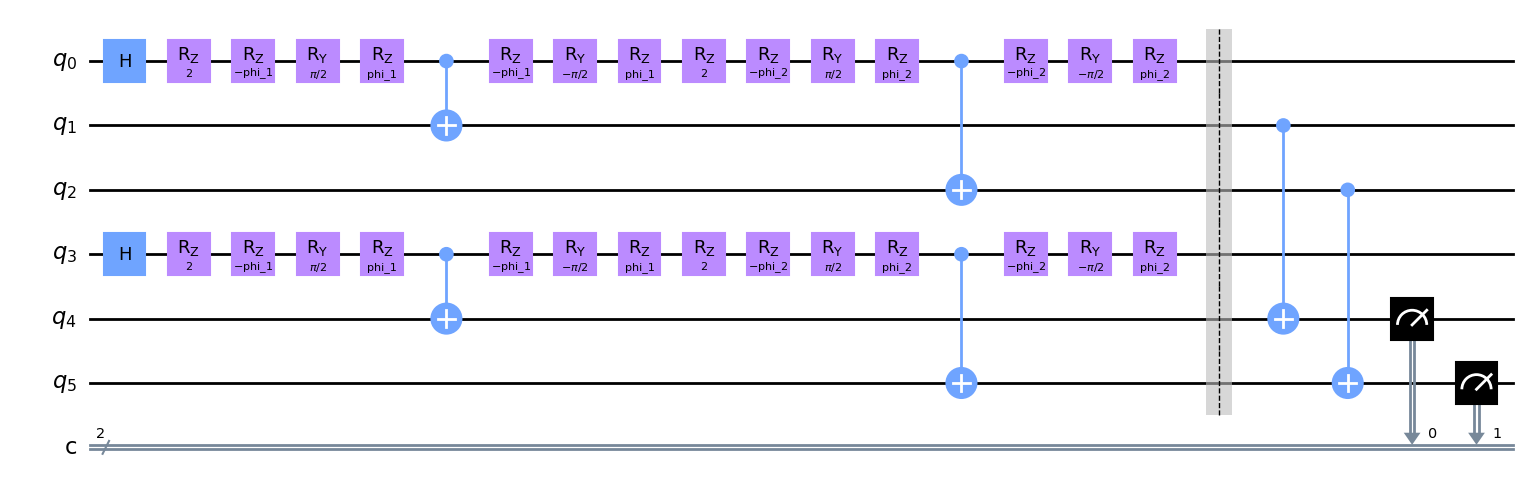

In [6]:
#making a new circuit for the cost function that we'll measure
measPartial = QuantumCircuit(6, 2) #6 qubits, and 4 classical bits to record outcome
measPartial.barrier(range(6)) #just draws a barrier on the circuit
measPartial.cx(1, 4)
measPartial.cx(2, 5)

measPartial.measure([4, 5], range(2)) #add the two measurements

#smooshing together the acutal circuit and the measurements on the end
qcPartial = measPartial.compose(circuit, range(6), front=True)

qcPartial.draw('mpl')

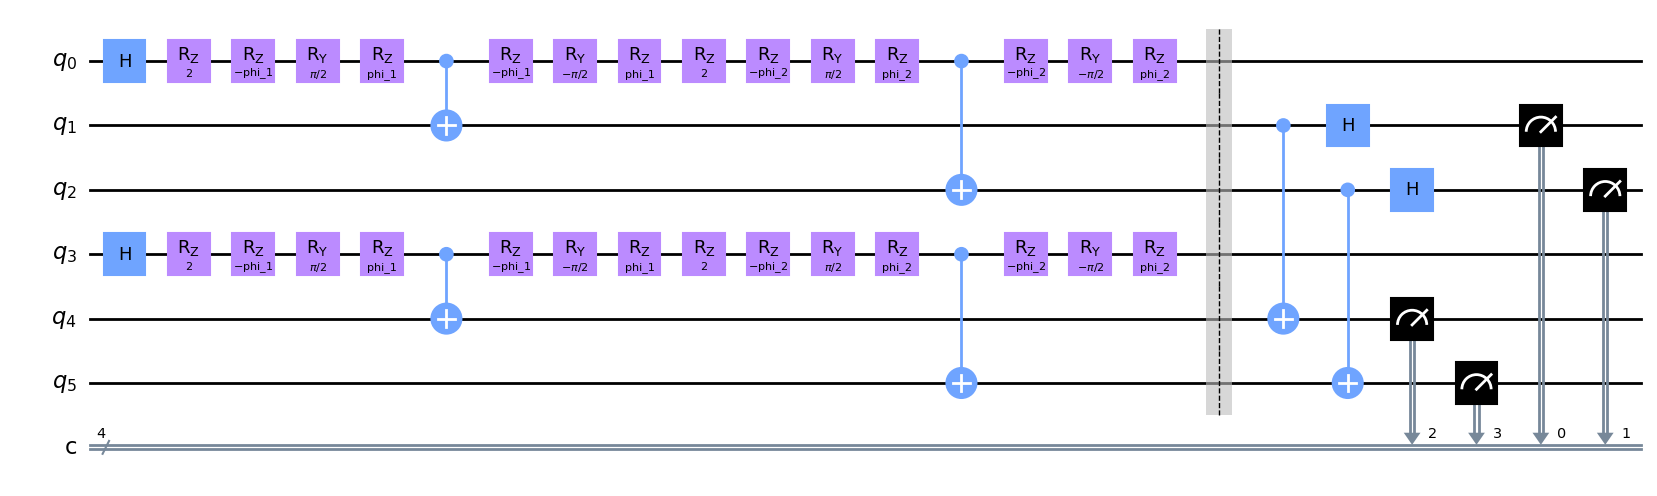

In [7]:
#making a new circuit for the cost function that we'll measure
measFull = QuantumCircuit(6, 4) #6 qubits, and 4 classical bits to record outcome
measFull.barrier(range(6)) #just draws a barrier on the circuit
measFull.cx(1, 4)
measFull.cx(2, 5)
measFull.h([1, 2])
#the hadamards are to calculate full cost

measFull.measure([1, 2, 4, 5], range(4)) #add the four measurements

#smooshing together the acutal circuit and the measurements on the end
qcFull = measFull.compose(circuit, range(6), front=True)

qcFull.draw('mpl')

In [28]:
#bind the phi parameter
#TODO: change back to 128 steps later

#phi_1_range = np.linspace(0, 2 * np.pi, 128)
#phi_2_range = np.linspace(0, 2 * np.pi, 128)
phi_range = list(itertools.product(np.linspace(-3, 3, 32), repeat=2))

full_circuits = [qcFull.assign_parameters({phi_1: phi_1_val, phi_2: phi_2_val})
            for (phi_1_val, phi_2_val) in phi_range]

partial_circuits = [qcPartial.assign_parameters({phi_1: phi_1_val, phi_2: phi_2_val})
            for (phi_1_val, phi_2_val) in phi_range]

In [29]:
# compile the circuit down to low-level QASM instructions
# supported by the backend (not needed for simple circuits)
compiled_circuit_partial = transpile(partial_circuits, simulator)

# Execute the circuit on the qasm simulator
job_partial = simulator.run(compiled_circuit_partial, shots=1024)

# Grab results from the job
result_partial = job_partial.result()

# Returns counts
counts_partial = result_partial.get_counts()
#print("\nTotal counts are:",counts_partial[0])
print(len(counts_partial))

1024


In [30]:
# compile the circuit down to low-level QASM instructions
# supported by the backend (not needed for simple circuits)
compiled_circuit_full = transpile(full_circuits, simulator)

# Execute the circuit on the qasm simulator
job_full = simulator.run(compiled_circuit_full, shots=1024)

# Grab results from the job
result_full = job_full.result()

# Returns counts
counts_full = result_full.get_counts()
#print("\nTotal counts are:",counts_full[0])

In [42]:
fails = {'0101', '0111', '1010', '1011', '1101', '1110'}
shots = 1024
cost_matrix = np.zeros(32**2)

#this needs to update, this now needs to be run for each element in counts_full and counts_partial which are each lists of count dictionaries
#TODO: update to run over all values of phi_1, then both phi_1 and phi_2

def compute_cost(full_counts, partial_counts):
    p_full = 0
    overlap_partial = 0
    for i in fails:
        if i in full_counts:
            p_full += full_counts[i]
    overlap_full = 1-2*(p_full/shots)
    overlap_partial = partial_counts['00']/shots
    return overlap_full-overlap_partial

for i in range(32**2):
    cost_matrix[i] = compute_cost(counts_full[i], counts_partial[i])

#print(p_full)
#print(overlap_full)
#print(overlap_partial)
#print(cost_matrix)

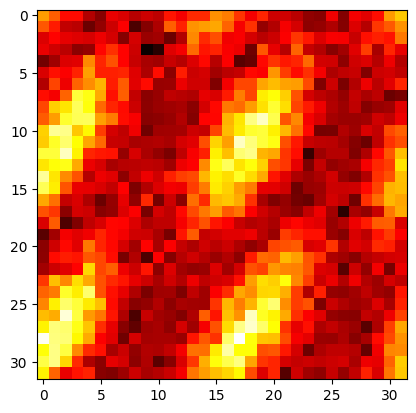

In [44]:
cost_matrix = np.reshape(cost_matrix, (32, 32))
cost_matrix = np.rot90(cost_matrix)


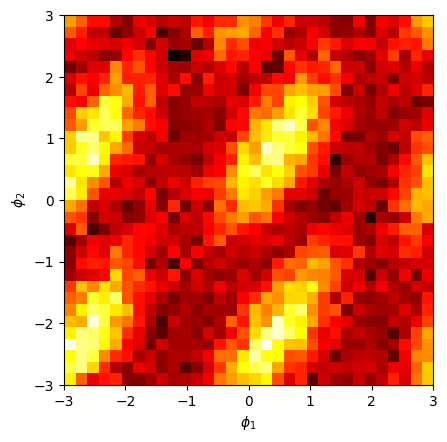

In [51]:
plt.imshow(cost_matrix, cmap='hot', interpolation='none', extent=[-3, 3, -3, 3])
plt.xlabel('$\phi_1$')
plt.ylabel('$\phi_2$')
plt.show()